In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math
import random

In [2]:
class Value:
    def __init__(self, data, children=(), op='',label=''):
        self.data=data;
        self.grad=0;
        self._prev=set(children)
        self._backward= lambda:None
        self.op=op
        self.label=label
    
    def __repr__(self):
        return f"Value(data:{self.data}"
        
    def __add__(self, other):
        other=other if isinstance(other,Value) else Value(other)
        out=Value(self.data+other.data,(self,other),'+')
        
        def _backward():
            self.grad+=1.0*out.grad
            other.grad+=1.0*out.grad
        out._backward=_backward
            
        return out
    
    def __radd__(self,other):
        return self+other
    
    def __neg__(self):
        return self* -1
    
    def __sub__(self,other):
        return self+(-other)
   
    def __pow__(self,other):
        assert isinstance(other,(int,float))
        out=Value(self.data**other,(self,),f'**{other}')
        
        def _backward():
            self.grad+=other*(self.data**(other-1))*out.grad
        out._backward=_backward
        return out
    
    
    def __mul__(self, other):
        other=other if isinstance(other,Value) else Value(other)
        out=Value(self.data*other.data,(self,other),op='*')
        
        def _backward():
            self.grad+=other.data*out.grad
            other.grad+=self.data*out.grad
        out._backward=_backward
        
        return out
    
    def __rmul__(self,other):
        return self*other

    def __truediv__(self,other):
        return self * (other**-1)
    
    def tanh(self):
        x=self.data
        t=(math.exp(2*x)-1)/(math.exp(2*x)+1)
        out=Value(t,(self,),op='tanh')
        
        def _backward():
            self.grad+=(1-t**2)*out.grad
        out._backward=_backward
        
        return out
   
    def __exp__(self):
        x=self.data
        out=Value(math.exp(x),(self,),'exp')
        
        def _backward():
            self.grad+=out.data* out.grad
        out._backward=_backward
        
        return out
    

    def backward(self):
        topo=[]
        visited=set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        self.grad=1.0
        for node in reversed(topo):
            node._backward()
            

In [3]:
class Neuron:
    def __init__(self, nin):
        self.w=[Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b=Value(random.uniform(-1,1))
    
    def __call__(self,x):
        act=self.b
        for wi,xi in zip(self.w,x):
            act=act + xi*wi
        out=act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]
    
class Layer:
    def __init__(self,nin,nout):
        self.neurons=[Neuron(nin) for _ in range(nout)]
        
    def __call__(self, x):
        outs=[n(x) for n in self.neurons]
        return outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
    
class MLP:
    def __init__(self, nin, nouts):
        sz=[nin] + nouts
        self.layers=[Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
        
    def __call__(self,x):
        for layer in self.layers:
            x=layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
    

In [4]:
from graphviz import Digraph
def trace(root):
    nodes, edges= set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child,v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot=Digraph(format='svg', graph_attr={'rankdir':'LR'})
    nodes, edges=trace(root)
    for n in nodes:
        uid=str(id(n))
        dot.node(name=uid, label="{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n.op:
            dot.node(name=uid + n.op, label=n.op)
            dot.edge(uid +n.op, uid)
            
    for n1,n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) +n2.op)
    return dot

In [5]:
n=MLP(3, [4,4,1])
xs=[
    [2.0,3.0,-1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]
ys=[1.0,-1.0,-1.0,1.0]
ypred=[n(x) for x in xs]
ypred

[[Value(data:0.9183724546287646],
 [Value(data:0.059946543980070946],
 [Value(data:0.9095957275121999],
 [Value(data:0.893772101565625]]

In [14]:
ys_val = [Value(y) for y in ys]

for i in range(30):
    ypred = [n(x)[0] for x in xs] 

    loss = sum(
        ((yout - ygt) ** 2 for ygt, yout in zip(ys_val, ypred)),
        Value(0.0)
    )

    for p in n.parameters():
        p.grad = 0.0

    loss.backward()

    for p in n.parameters():
        p.data -= 0.1 * p.grad

    print(i, loss.data)


0 0.001042101351043673
1 0.0010378364107977596
2 0.001033605827814881
3 0.0010294091902052615
4 0.0010252460926253443
5 0.0010211161361485081
6 0.0010170189281386282
7 0.0010129540821266646
8 0.0010089212176901897
9 0.0010049199603356731
10 0.0010009499413835945
11 0.0009970107978560445
12 0.000993102172367104
13 0.0009892237130156168
14 0.0009853750732805552
15 0.000981555911918558
16 0.0009777658928640162
17 0.0009740046851313101
18 0.0009702719627192517
19 0.0009665674045177058
20 0.0009628906942162935
21 0.0009592415202150912
22 0.0009556195755374322
23 0.0009520245577444599
24 0.0009484561688517413
25 0.0009449141152476052
26 0.0009413981076132725
27 0.0009379078608448076
28 0.0009344430939766915
29 0.0009310035301070765


In [15]:
ypred

[Value(data:0.9850357326732286,
 Value(data:-0.9866747001402061,
 Value(data:-0.9826092048067122,
 Value(data:0.9849311294493683]

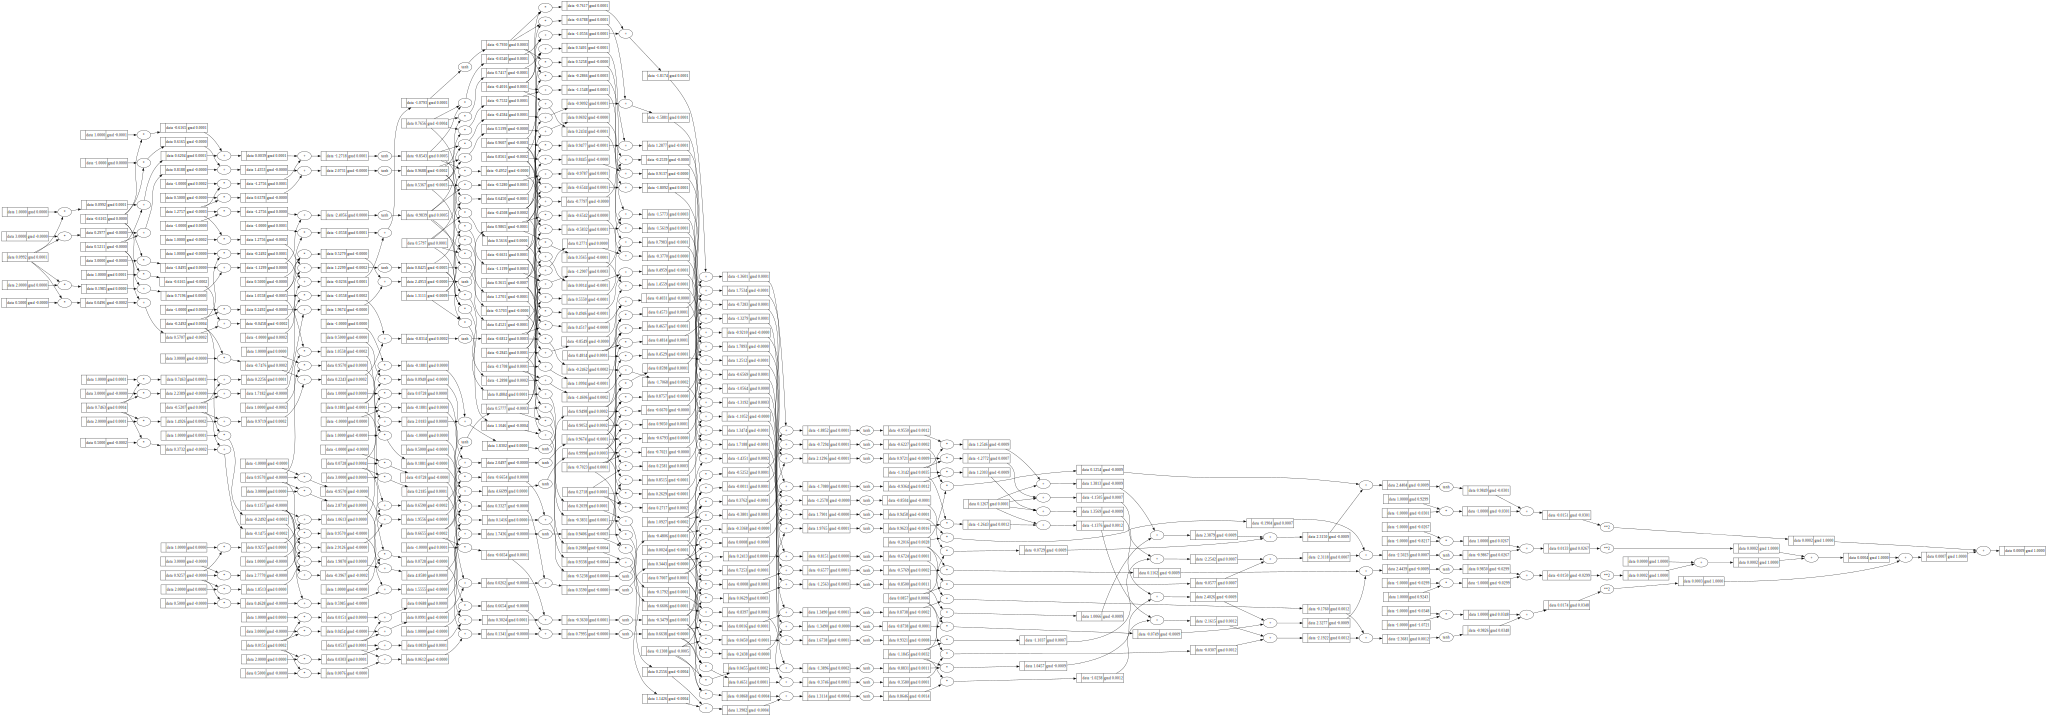

In [16]:
draw_dot(loss)